In [2]:
from qiskit import IBMQ, pulse, schedule
from qiskit.circuit import QuantumCircuit, Gate, Parameter
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from sympy import *
from sympy.physics.quantum import *

import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [3]:
IBMQ.load_account() # load if no backend satisfies
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibm_oslo')
qubit = 0
backend_config = backend.configuration()
dt = backend_config.dt  
backend_defaults = backend.defaults()

# The Matrix (1999)

In this section we look at how Hadamard gate is synthesized from elementary gates, namely $X_{\theta}^{(mn)}$ and $Z_{\phi}^{(mn)}$. The cannonical form of $H_3$ is 

\begin{align}
H_3 = \dfrac{1}{\sqrt{3}}\begin{pmatrix}
1 & 1 & 1 \\
1 & \omega & \omega^2 \\
1 & \omega^2 & \omega \end{pmatrix}
\end{align}

where $\omega = \exp[j(2\pi/3)]$. We also introduce two sets of elementary rotations in their respective computational subspaces. First is in the (01) subspace,

\begin{align}
X_{\theta}^{(01)} = \begin{pmatrix}
\cos\left(\dfrac{\theta}{2}\right) & -j\sin\left(\dfrac{\theta}{2}\right) & 0 \\
-j\sin\left(\dfrac{\theta}{2}\right) & \cos\left(\dfrac{\theta}{2}\right) & 0 \\
0 & 0 & 1 \end{pmatrix}\qquad\qquad
Z_{\phi}^{(01)} = \begin{pmatrix}
\exp\left(-j\dfrac{\phi}{2}\right) & 0 & 0 \\
0 & \exp\left(j\dfrac{\phi}{2}\right) & 0 \\
0 & 0 & 1 \end{pmatrix},
\end{align}

and secondly in the (12) subspace, 

\begin{align}
X_{\theta}^{(12)} = \begin{pmatrix}
1 & 0 & 0 \\
0 & \cos\left(\dfrac{\theta}{2}\right) & -j\sin\left(\dfrac{\theta}{2}\right) \\
0& -j\sin\left(\dfrac{\theta}{2}\right) & \cos\left(\dfrac{\theta}{2}\right) 
\end{pmatrix}\qquad\qquad
Z_{\phi}^{(12)} = \begin{pmatrix}
1 & 0 & 0 \\
0 & \exp\left(-j\dfrac{\phi}{2}\right) & 0 \\
0 & 0 & \exp\left(j\dfrac{\phi}{2}\right)
\end{pmatrix},
\end{align}

In [152]:
theta = Symbol('theta')
phi = Symbol('phi')
phi_6 = Symbol('\phi_6')
phi_5 = Symbol('\phi_5')
phi_4 = Symbol('\phi_4')
omega = exp(I*2*3.14159/3)

# |0> state
ground = Matrix([
        [1],
        [0],
        [0]
    ])

# Hadamard gate
def H3(omega):
    return Matrix([
        [1/sqrt(3), 1/sqrt(3), 1/sqrt(3)],
        [1/sqrt(3), 1/sqrt(3)*omega, 1/sqrt(3)*omega**2],
        [1/sqrt(3), 1/sqrt(3)*omega**2, 1/sqrt(3)*omega]
    ])

# Rotation along the X axis in (12) subspace
def X12(theta):
    return Matrix([
        [1, 0, 0],
        [0, cos(theta/2), -I*sin(theta/2)],
        [0, -I*sin(theta/2), cos(theta/2)]
    ])

# Rotation along the Z axis in (12) subspace
# Note that Z and P are just different representation of 
# the same effect /
def Z12(phi):
    return Matrix([
        [1, 0, 0],
        [0, exp(-I*phi/2), 0],
        [0, 0, exp(I*phi/2)]
    ])

def P2(phi):
    return Matrix([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, exp(I*phi)]
    ])

# Rotation along the X axis in (01) subspace
def X01(theta):
    return Matrix([
        [cos(theta/2), -I*sin(theta/2), 0],
        [-I*sin(theta/2), cos(theta/2), 0],
        [0, 0, 1]
    ])

# Rotation along the Z axis in (01) subspace
def Z01(phi):
    return Matrix([
        [exp(-I*phi/2), 0, 0],
        [0, exp(I*phi/2), 0],
        [0, 0, 1]
    ])

def P0(phi):
    return Matrix([
        [exp(I*phi), 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])

# Diagonal matrix
def diagonal(phi_6, phi_5, phi_4):
    return Matrix([
        [exp(I*phi_6), 0, 0],
        [0, exp(I*phi_5), 0],
        [0, 0, exp(I*phi_4)]
    ])

Our decomposition (see [here](https://github.com/ngdnhtien/randomized-benchmarking/blob/main/probing_clifford.ipynb)) is slightly different from that of Waterloo team. We both acknowledge the fact that any SU(3) gate can be written as 

\begin{align} 
U &= U_d(\phi_6, \phi_5, \phi_4)\cdot R_{\phi_3}^{(01)}(\theta_3) \cdot R_{\phi_2}^{(12)}(\theta_2) \cdot R_{\phi_1}^{(01)}(\theta_1)\\
&= U_d(\phi_6, \phi_5, \phi_4) \cdot P_{-\phi_3}^{0} \cdot X_{\theta_3}^{(01)} \cdot P_{\phi_3}^{0} \cdot P_{\phi_2}^{2} \cdot X_{\theta_2}^{(12)} \cdot P_{-\phi_2}^{2} \cdot P_{-\phi_1}^{0} \cdot X_{\theta_1}^{(01)} \cdot P_{\phi_1}^{0}\\
&= U_d(\phi_6,\phi_5,\phi_4)\cdot Z_{\phi_3}^{(01)} \cdot X_{\theta_3}^{(01)} \cdot Z_{-\phi_3}^{(01)} \cdot Z_{\phi_2}^{(12)} \cdot X_{\theta_2}^{(12)} \cdot Z_{-\phi_2}^{(01)} \cdot Z_{\phi_1}^{(01)} \cdot X_{\theta_1}^{(01)} \cdot Z_{-\phi_1}^{(01)}
\end{align}

The maths says that $\theta_1, \theta_2, \theta_3, \phi_1, \phi_2, \phi_3, \phi_4, \phi_5, \phi_6$ are $(1.5708,
 1.91063,
 1.5708,
 -2.61799,
 -2.61799,
 -1.0472,
 2.0944,
 -3.14159,
 -6.80678)$. So, for the Hadamard gate, we would like to observe on the schedule something like
 
 \begin{align}
H = U_d( -6.80678,-3.14159,2.0944)\cdot Z_{-1.0472}^{(01)} \cdot X_{1.5708}^{(01)} \cdot Z_{1.0472}^{(01)} \cdot Z_{-2.61799}^{(12)} \cdot X_{1.91063}^{(12)} \cdot Z_{2.61799}^{(12)} \cdot Z_{−2.61799}^{(01)} \cdot X_{1.5708}^{(01)} \cdot Z_{2.61799}^{(01)}\end{align}



In [146]:
R01_oneway = P0(phi)*X01(theta)*P0(-phi)
R01_theotherway = Z01(-phi)*X01(theta)*Z01(phi) 
R12_oneway = P2(phi)*X12(theta)*P2(-phi)
R12_theotherway = Z12(phi)*X12(theta)*Z12(-phi)

R12_oneway - R12_theotherway - R01_oneway + R01_theotherway

Matrix([
[0, 0, 0],
[0, 0, 0],
[0, 0, 0]])

In [144]:
# M1 = P0(-phi)*X01(theta)*P0(phi)*P2(phi)*X12(theta)*P2(-phi)*P0(-phi)*X01(theta)*P0(phi) 
# M2 = Z01(phi)*X01(theta)*Z01(-phi)*Z12(phi)*X12(theta)*Z12(-phi)*Z01(phi)*X01(theta)*Z01(-phi)

M1 = P0(-phi)*X01(theta)*P0(phi)*P2(phi)*X12(theta)*P2(-phi)*P0(-phi)*X01(theta)*P0(phi)
M2 = Z01(phi)*X01(theta)*Z01(-phi)*Z12(phi)*X12(theta)*Z12(-phi)*Z01(phi)*X01(theta)*Z01(-phi)

M = M1 - M2

for i in range(9):
    M[i] = simplify(M[i])

M

Matrix([
[0, 0, 0],
[0, 0, 0],
[0, 0, 0]])

Is this Hadamard? 

In [153]:
M = H3(omega) - diagonal(-6.80678, -3.14159, 2.0944)*Z01(-1.0472)*X01(1.5708)*Z01(1.0472)*Z12(-2.61799)*X12(1.91063)*Z12(2.61799)*Z01(-2.61799)*X01(1.5708)*Z01(2.61799)

for i in range(9):
    M[i] = simplify(M[i])

M

Matrix([
[                                                                                    -0.577347957396538 + sqrt(3)/3 - 5.67907583001737e-6*I, sqrt(3)/3 + 0.499999999996627*I*(-0.500000177350206 + 0.866025301391225*I) + 0.288675795189052*I*(0.866022137975322 + 0.500005656504657*I),                                            -0.577350668951063 + sqrt(3)/3 - 1.53205184206291e-6*I],
[sqrt(3)/3 + 0.499999999996627*I*(-0.500000177350207 + 0.866025301391225*I) + 0.288675795189052*I*(0.866022137975322 + 0.500005656504657*I),                                             0.288672898215281 - 0.500001070574849*I + sqrt(3)*(-0.499998467948436 + 0.866026288313015*I)/3, (0.866024791582939 - 0.500001060362603*I)*(sqrt(3)*exp(4.71238666666667*I) + 1.7320456446887*I)/3],
[                                                                                    -0.577350668906875 + sqrt(3)/3 - 7.30555853169493e-6*I,                                          (0.866029791550241 - 0.499992400089687*I)*(sqrt

In [ ]:
It does not look like a 

# Pulsating Pulses

In [7]:
f01 = 4925170000.0
f12 = 4581552617.648945

d12_duration = 544
d12_amplitude = 0.10879003883868105
d12_sigma = 40

d01_duration = 544
d01_sigma = 67
d01_amplitude = 0.07999888439750123

$X_\pi^{(01)}$ instructions

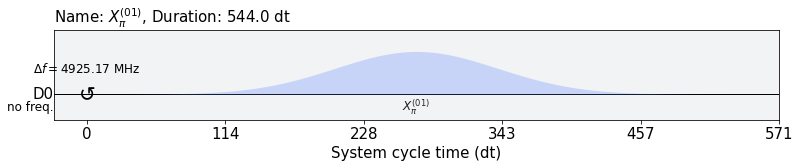

In [8]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(01)}$') as inst_xpi01:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.play(pulse.Gaussian(duration=d01_duration,
                                  amp=d01_amplitude,
                                  sigma=d01_sigma,
                                  name=r'$X_{\pi}^{(01)}$'), drive_chan)

xpi01 = Gate('xp01', 1, [])
inst_xpi01.draw()

$X_\pi^{(12)}$ instructions

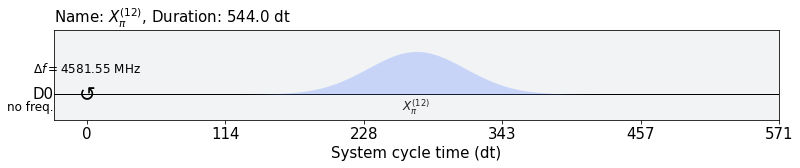

In [9]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(12)}$') as inst_xpi12:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f12, drive_chan)
    pulse.play(pulse.Gaussian(duration=d12_duration,
                                  amp=d12_amplitude,
                                  sigma=d12_sigma,
                                  name=r'$X_{\pi}^{(12)}$'), drive_chan)

xpi12 = Gate('xp12', 1, [])
inst_xpi12.draw()

In [10]:
# 0 state
qc_ground = QuantumCircuit(1, 1)
qc_ground.measure(0, 0)

# 1 state
qc_one = QuantumCircuit(1, 1)
qc_one.append(xpi01, [0])
qc_one.measure(0, 0)
qc_one.add_calibration(xpi01, (0,), inst_xpi01, [])

# 2 state 
x12_gate = Gate("one_two_pulse", 1, [])
qc_x12 = QuantumCircuit(1, 1)
qc_x12.append(xpi01, [0])
qc_x12.append(xpi12, [0])
qc_x12.measure(0, 0)
qc_x12.add_calibration(xpi12, (0,), inst_xpi12, [])
qc_x12.add_calibration(xpi01, (0,), inst_xpi01, [])

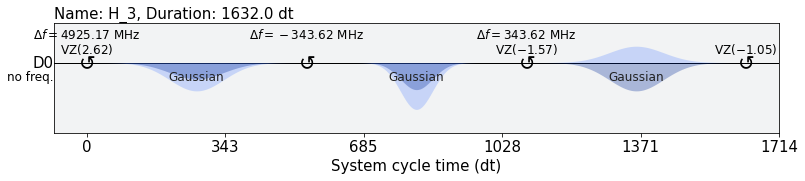

In [16]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'H_3') as Hadamard:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(-2.61799, drive_chan):
        pulse.play(pulse.Gaussian(duration=d01_duration,
                                 amp=(1.5708/np.pi)*d01_amplitude,
                                 sigma=d01_sigma), drive_chan)
    pulse.set_frequency(f12, drive_chan)
    with pulse.phase_offset(-2.61799, drive_chan):
        pulse.play(pulse.Gaussian(duration=d12_duration,
                                 amp=(1.91063/np.pi)*d12_amplitude,
                                 sigma=d12_sigma), drive_chan)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(-1.0472, drive_chan):
        pulse.play(pulse.Gaussian(duration=d01_duration,
                                 amp=(1.5708/np.pi)*d01_amplitude,
                                 sigma=d01_sigma), drive_chan)
Hadamard.draw()

with pulse

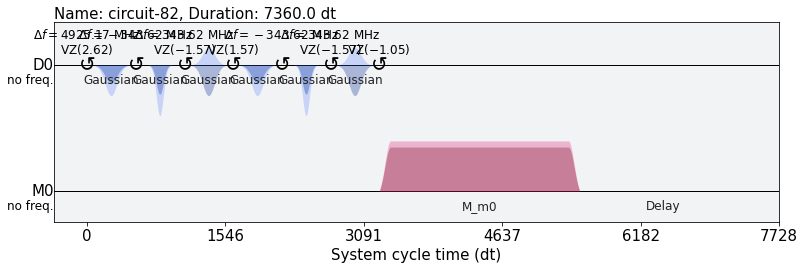

In [35]:
qc = QuantumCircuit(1,1)

H = Gate('Hadamard', 1, [])

qc.append(H, [0])
qc.append(H, [0])
qc.measure(0,0)
qc.add_calibration(H, (0,), Hadamard, [])

sched = schedule(qc, backend)
sched.draw()

In [22]:
# Assemble the schedules into a program
IQ_012_job = backend.run([qc_ground, qc_one, qc_x12], 
                          meas_level=1, 
                          meas_return='single', 
                          shots=2**13)

In [ ]:
job_monitor(IQ_012_job)

Job Status: job is queued (12)    

In [11]:
IQ_012_job = backend.retrieve_job('62fdb3259d39d61d129b74fa')

In [12]:
scale_factor = 1e-7

def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout = 120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [13]:
# Get job data (single); split for zero, one and two
IQ_012_data = get_job_data(IQ_012_job, average=False)

zero_data = IQ_012_data[0]
one_data = IQ_012_data[1]
two_data = IQ_012_data[2]

In [14]:
def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data), 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

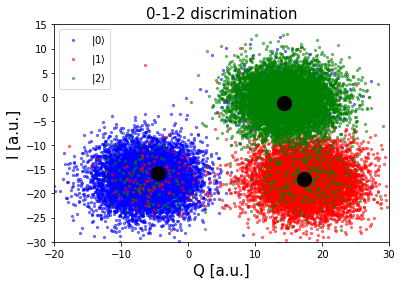

In [15]:
x_min = -20
x_max = 30
y_min = -30
y_max = 15

import matplotlib.pyplot as plt
IQ_012_plot(x_min, x_max, y_min, y_max)

In [16]:
def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

In [17]:
# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  
two_data_reshaped = reshape_complex_vec(two_data)  

IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
print(IQ_012_data.shape) # verify IQ data shape

(24576, 2)


In [18]:
NUM_SHOTS = 2**13

In [19]:
from sklearn.model_selection import train_test_split

# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(NUM_SHOTS) # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2*np.ones(NUM_SHOTS)))
print(len(state_012))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)

24576


In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Set up the LDA
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)

LinearDiscriminantAnalysis()

In [21]:
# test on some simple data 
print(LDA_012.predict([[0, 0], [-10, 0], [-15, -5]]))

[2. 0. 0.]


In [22]:
# Compute accuracy
score_012 = LDA_012.score(IQ_012_test, state_012_test)
print(score_012)

0.9418131510416666


In [23]:
# Plot separatrix on top of scatter
def separatrixPlot(lda, x_min, x_max, y_min, y_max, shots):
    nx, ny = shots, shots

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='black')

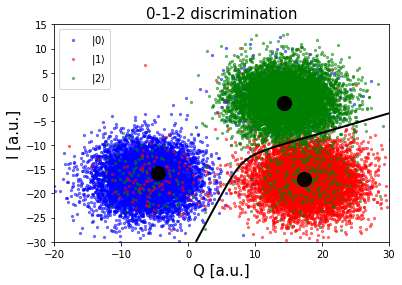

In [24]:
IQ_012_plot(x_min, x_max, y_min, y_max)
separatrixPlot(LDA_012, x_min, x_max, y_min, y_max, NUM_SHOTS)

In [20]:
num_shots = 2**13

job = backend.run(qc, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


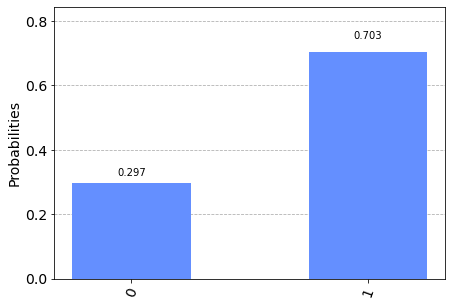

In [21]:
counts = job.result().get_counts()
plot_histogram(counts)